In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Geod, CRS, Transformer
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

image_path = "/mnt/c/Users/Bezu0001/data/satellite_imagery/luggye_geotiff.tiff"

In [2]:
polyline = [(90.3195, 28.0963), (90.315, 28.0928), (90.310, 28.091), (90.305, 28.091), (90.3, 28.092), (90.295, 28.094)]

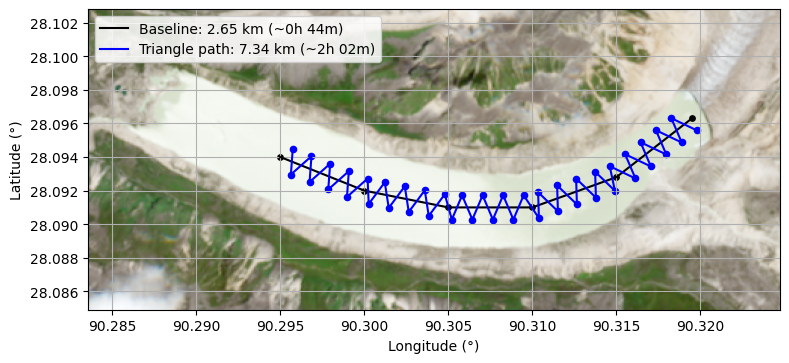

In [3]:
A_m, lam_m = 80.0, 120.0  # triangle amplitude (m), wavelength (m)
speed_mps = 1.0                         # for time estimates

# --- reproject raster to EPSG:4326 & plot (same look as before) ---
with rio.open(image_path) as src:
    dst_crs = "EPSG:4326"
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    nb = min(3, src.count)
    dst = np.empty((nb, height, width), dtype=src.dtypes[0])
    for i in range(nb):
        reproject(
            source=src.read(i+1),
            destination=dst[i],
            src_transform=src.transform, src_crs=src.crs,
            dst_transform=transform,   dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

left, top = transform.c, transform.f
right = left + transform.a * dst.shape[2]
bottom = top  + transform.e * dst.shape[1]
extent = [left, right, bottom, top]

plt.figure(figsize=(8,6))
if dst.shape[0] == 1:
    plt.imshow(dst[0], extent=extent, origin="upper")
else:
    rgb = np.transpose(dst[:3], (1,2,0)).astype(np.float32)
    rgb /= np.nanmax(rgb) + 1e-12
    plt.imshow(rgb, extent=extent, origin="upper")

# --- original polyline (we'll label it for legend) ---
plt.plot(*zip(*polyline), 'k-', label="Base")     # temporary label; will overwrite below
plt.scatter(*zip(*polyline), c='k', s=15, label='_nolegend_')

# --- triangle-wave VERTICES only (no refined spacing) ---
lon0, lat0 = polyline[0]
zone = int((lon0 + 180)//6) + 1
crs_xy = CRS.from_epsg(32600+zone if lat0 >= 0 else 32700+zone)
fwd = Transformer.from_crs("EPSG:4326", crs_xy, always_xy=True)
inv = Transformer.from_crs(crs_xy, "EPSG:4326", always_xy=True)

lon, lat = np.array(polyline).T
x, y = fwd.transform(lon, lat)
x, y = np.asarray(x), np.asarray(y)

dx, dy = np.diff(x), np.diff(y)
seg = np.hypot(dx, dy)
S = np.r_[0.0, np.cumsum(seg)]
L = float(S[-1])

s = np.arange(lam_m/4, L + 1e-9, lam_m/2)
lon_v = np.array([]); lat_v = np.array([])  # defaults if too short
if s.size:
    i = np.clip(np.searchsorted(S, s, side="right") - 1, 0, len(seg)-1)
    t = (s - S[i]) / np.maximum(seg[i], 1e-12)
    xs, ys = x[i] + dx[i]*t, y[i] + dy[i]*t
    tx, ty = dx[i]/np.maximum(seg[i],1e-12), dy[i]/np.maximum(seg[i],1e-12)
    nx, ny = -ty, tx
    sign = 1.0 - 2.0*(np.arange(s.size) % 2)  # +1, -1, +1, ...
    xo, yo = xs + nx*A_m*sign, ys + ny*A_m*sign
    lon_v, lat_v = inv.transform(xo, yo)
    lon_v, lat_v = np.asarray(lon_v), np.asarray(lat_v)
    plt.plot(lon_v, lat_v, '-', label="Triangle", color = 'blue')
    plt.scatter(lon_v, lat_v, s=20, label='_nolegend_', color = 'blue')

# --- lengths (geodesic, WGS84) + legend labels with time @ 1 m/s ---
g = Geod(ellps="WGS84")
def geodesic_length_m(ll):
    return sum(g.inv(a, b, c, d)[2] for (a, b), (c, d) in zip(ll, ll[1:]))

L_base = geodesic_length_m(polyline)
L_tri  = geodesic_length_m(list(zip(lon_v, lat_v))) if len(lon_v) > 1 else 0.0

h_base = L_base / (speed_mps * 3600.0)
h_tri  = L_tri  / (speed_mps * 3600.0)
hhmm = lambda H: f"{int(H):d}h {int(round((H-int(H))*60)):02d}m"

base_label = f"Baseline: {L_base/1000:.2f} km (~{hhmm(h_base)})"
tri_label  = f"Triangle path: {L_tri/1000:.2f} km (~{hhmm(h_tri)})"

# Update line labels for legend
lines = plt.gca().get_lines()
for ln in lines:
    if ln.get_label() == "Base":
        ln.set_label(base_label)
    elif ln.get_label() == "Triangle":
        ln.set_label(tri_label)

plt.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.85)

plt.gca().set_aspect("equal")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.grid(True)
plt.tight_layout()
plt.show()
